In [1]:
import warnings
from collections import Counter
import IPython
from IPython.core.display import display
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict

import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *
from tqdm import tqdm

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

# A. Load data, preprocess, and calculate accuracy

In [2]:
X, y, le = read_data(dataset)

In [3]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# B. Plot confidence scores for all the data

In [4]:
X_train, y_train = X, y
clf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores

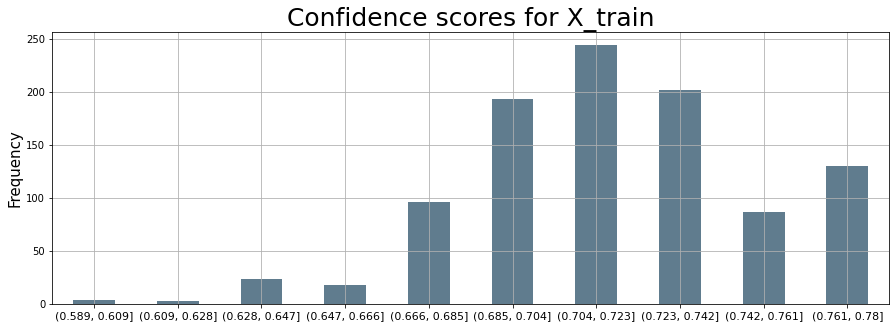

In [5]:
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Select C as the middle of top intervals

In [8]:
# Create bucket (intervals) from generated data
top_c = 10
conf_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values

# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]
top_c_lst = sorted(round(x, 4) for x in top_c_lst)

In [9]:
top_c_lst

[0.599, 0.6185, 0.6375, 0.6565, 0.6755, 0.6945, 0.7135, 0.7325, 0.7515, 0.7705]

# D. Train one CTGAN with middle of intervals (10 Confidence levels)

In [10]:
# X_all = np.concatenate([X_train, y_train.reshape(-1,1)], axis=1)
# X_train = X_all
X_train_pd = pd.DataFrame(X_train)



# train CTGAN
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
#confidence_level = c
gen_lr = 2e-5
loss = 'log'

#now ctgan synthesizer gets conf levels as input
rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss,
                            confidence_levels=top_c_lst
                            )
#print(rf_ctgan.confidence_levels)

print(f"Training CTGAN for c list = {top_c_lst} ...")
#removed conf level from fit input arguements
allconf_levels_hist = rf_ctgan.fit(train_data=z,
                                   epochs=epochs,
                                   gen_lr=gen_lr,
                                   verbose=False
                                  )

#print("\nhistory of all confidence levels:\n")
#print(allconf_levels_hist)
#print("\n\n")
# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")
# plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
# print()

#allsamplesInv = 0
#allDataFrames = []
allgeninv= 0
alldataframescoverage =[]
alldataframesprecision =[]
#add here conf loop, send each conf to samples as input each loop
for c in top_c_lst:
    print("\tGenerate samples to same dist...")
    # Generate samples to same dist
    samples = 100000
    gen_data = rf_ctgan.sample(samples,c)
    y_prob = rf.predict_proba(gen_data)
    y_conf_gen = y_prob[:, 0]  # confidence scores


    # ans is the indices of gen_data to make the same dist
    ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)
    gen_data_same_dist = gen_data.iloc[ans]
    y_conf_gen_same_dist = y_conf_gen[ans]

    # inverse the generated data
    scaler = get_scaler(preprocessor)
    gen_data_inv = scaler.inverse_transform(gen_data_same_dist)
    gen_data_inv = pd.DataFrame(gen_data_inv)
    
    #calc all inv
    
    allgeninv = allgeninv + gen_data_inv.size
    #calc end

    # y_conf_gen_same_dist, gen_data_inv what we want
    # results
    # E. Calculate coverage for each similarity and conf diff thresholds

    #sum all geninvsamples
    #allsamplesInv =allsamplesInv + gen_data_inv.size()

    print(f"\tWorking on results...")
    results,coverage, precision = table(gen_data_inv, X_train_pd, y_conf_gen_same_dist, y_conf_train)
    
    print("datagen inv size:")
    print(gen_data_inv.size)
    print("\n")
    
    #keep all data frames
    alldataframescoverage.append([coverage,gen_data_inv.size])
    alldataframesprecision.append([precision,gen_data_inv.size])
   # allDataFrames.append(results)

    print(f"\tResults for confidence level = {c}")
    display(results)
    
    
    

print("allgen in size")
print(allgeninv)
print("\n")
print("calculate weighted average results\n")
a= alldataframescoverage[0][0] *0
#display(a)
for index in range(len(alldataframescoverage)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    a= a+ alldataframescoverage[index][0]*alldataframescoverage[index][1]
a = a/allgeninv
#display weighted averaged coverage
display(a) 


b= alldataframesprecision[0][0] *0
#display(b)
for index in range(len(alldataframesprecision)):
    #func = lambda s1, s2: s1 + s2*alldataframes[index][1]
    b= b+ alldataframesprecision[index][0]*alldataframesprecision[index][1]
b = b/allgeninv
#display weighted averaged precision
display(b) 

a = a.astype(str)
b = b.astype(str)

result_weighted_Average = a+" | "+b

print("result_weighted_Average:\n")
display(result_weighted_Average)



Training CTGAN for c list = [0.599, 0.6185, 0.6375, 0.6565, 0.6755, 0.6945, 0.7135, 0.7325, 0.7515, 0.7705] ...
	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.599


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.9,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8
0.85,100.0 | 95.5,100.0 | 96.4,100.0 | 96.6,100.0 | 96.6,100.0 | 96.6
0.90,100.0 | 92.8,100.0 | 95.0,100.0 | 95.1,100.0 | 95.1,100.0 | 95.1
0.95,100.0 | 84.3,100.0 | 91.1,100.0 | 91.2,100.0 | 91.2,100.0 | 91.2
0.99,52.5 | 46.3,84.7 | 70.0,88.9 | 71.2,89.1 | 71.2,89.1 | 71.2


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.6185


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.8,100.0 | 98.4,100.0 | 98.4,100.0 | 98.4,100.0 | 98.4
0.85,100.0 | 96.8,100.0 | 97.8,100.0 | 97.9,100.0 | 97.9,100.0 | 97.9
0.90,100.0 | 94.9,100.0 | 96.2,100.0 | 96.2,100.0 | 96.2,100.0 | 96.2
0.95,100.0 | 88.9,100.0 | 91.7,100.0 | 92.0,100.0 | 92.0,100.0 | 92.0
0.99,56.1 | 55.7,86.8 | 68.2,88.9 | 69.6,88.9 | 69.8,88.9 | 69.8


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.6375


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.1,100.0 | 97.6,100.0 | 97.6,100.0 | 97.6,100.0 | 97.6
0.85,100.0 | 96.2,100.0 | 96.4,100.0 | 96.4,100.0 | 96.4,100.0 | 96.4
0.90,100.0 | 94.7,100.0 | 95.4,100.0 | 95.5,100.0 | 95.5,100.0 | 95.5
0.95,99.7 | 89.7,100.0 | 92.4,100.0 | 92.7,100.0 | 92.7,100.0 | 92.7
0.99,39.3 | 51.9,83.1 | 69.2,89.0 | 69.7,89.6 | 69.7,89.6 | 69.7


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.6565


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.5,100.0 | 97.2,100.0 | 97.3,100.0 | 97.3,100.0 | 97.3
0.85,100.0 | 95.3,100.0 | 96.4,100.0 | 96.5,100.0 | 96.5,100.0 | 96.5
0.90,100.0 | 93.2,100.0 | 94.4,100.0 | 94.5,100.0 | 94.5,100.0 | 94.5
0.95,100.0 | 87.3,100.0 | 91.2,100.0 | 91.2,100.0 | 91.2,100.0 | 91.2
0.99,44.7 | 48.7,82.8 | 68.3,88.4 | 69.1,88.4 | 69.2,88.4 | 69.2


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.6755


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.2,100.0 | 97.7,100.0 | 97.7,100.0 | 97.7,100.0 | 97.7
0.85,100.0 | 95.8,100.0 | 96.7,100.0 | 96.8,100.0 | 96.8,100.0 | 96.8
0.90,100.0 | 93.5,100.0 | 94.8,100.0 | 94.9,100.0 | 94.9,100.0 | 94.9
0.95,100.0 | 87.6,100.0 | 90.1,100.0 | 90.2,100.0 | 90.2,100.0 | 90.2
0.99,56.3 | 56.0,84.1 | 68.4,90.0 | 69.6,90.1 | 69.7,90.1 | 69.7


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.6945


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.4,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8
0.85,100.0 | 96.1,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0,100.0 | 97.0
0.90,100.0 | 93.9,100.0 | 94.8,100.0 | 94.8,100.0 | 94.8,100.0 | 94.8
0.95,99.9 | 88.2,100.0 | 91.0,100.0 | 91.1,100.0 | 91.1,100.0 | 91.1
0.99,51.5 | 49.0,85.2 | 66.7,89.5 | 68.2,90.5 | 68.3,90.5 | 68.3


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.7135


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.9,100.0 | 98.1,100.0 | 98.2,100.0 | 98.2,100.0 | 98.2
0.85,100.0 | 96.7,100.0 | 97.7,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8
0.90,100.0 | 95.2,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0,100.0 | 96.0
0.95,100.0 | 88.9,100.0 | 91.6,100.0 | 91.7,100.0 | 91.7,100.0 | 91.7
0.99,55.3 | 53.5,85.5 | 69.4,88.8 | 70.2,88.9 | 70.2,88.9 | 70.2


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.7325


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.8,100.0 | 98.2,100.0 | 98.2,100.0 | 98.2,100.0 | 98.2
0.85,100.0 | 96.5,100.0 | 97.4,100.0 | 97.5,100.0 | 97.5,100.0 | 97.5
0.90,100.0 | 94.7,100.0 | 96.1,100.0 | 96.1,100.0 | 96.1,100.0 | 96.1
0.95,100.0 | 86.5,100.0 | 93.3,100.0 | 93.7,100.0 | 93.7,100.0 | 93.7
0.99,38.5 | 47.2,83.0 | 69.9,86.6 | 70.9,87.3 | 70.9,87.3 | 70.9


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.7515


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 98.2,100.0 | 98.4,100.0 | 98.4,100.0 | 98.4,100.0 | 98.4
0.85,100.0 | 97.6,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8,100.0 | 97.8
0.90,100.0 | 96.0,100.0 | 96.5,100.0 | 96.5,100.0 | 96.5,100.0 | 96.5
0.95,100.0 | 89.6,100.0 | 92.1,100.0 | 92.2,100.0 | 92.2,100.0 | 92.2
0.99,55.0 | 52.2,86.2 | 67.7,88.3 | 68.7,88.4 | 68.7,88.5 | 68.7


	Generate samples to same dist...
	Working on results...
datagen inv size:
24000


	Results for confidence level = 0.7705


,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 96.0,100.0 | 96.5,100.0 | 96.5,100.0 | 96.5,100.0 | 96.5
0.85,100.0 | 94.9,100.0 | 96.0,100.0 | 96.1,100.0 | 96.1,100.0 | 96.1
0.90,100.0 | 90.8,100.0 | 94.6,100.0 | 94.6,100.0 | 94.6,100.0 | 94.6
0.95,100.0 | 78.8,100.0 | 90.0,100.0 | 90.3,100.0 | 90.3,100.0 | 90.3
0.99,48.3 | 39.1,82.3 | 67.9,85.6 | 69.0,86.0 | 69.0,86.0 | 69.0


allgen in size
240000


calculate weighted average results



,0.01,0.05,0.10,0.15,0.20
0.80,100.00,100.00,100.0,100.00,100.00
0.85,100.00,100.00,100.0,100.00,100.00
0.90,100.00,100.00,100.0,100.00,100.00
0.95,99.96,100.00,100.0,100.00,100.00
0.99,49.75,84.37,88.4,88.72,88.73


,0.01,0.05,0.10,0.15,0.20
0.80,97.28,97.77,97.79,97.79,97.79
0.85,96.14,96.96,97.04,97.04,97.04
0.90,93.97,95.38,95.42,95.42,95.42
0.95,86.98,91.45,91.63,91.63,91.63
0.99,49.96,68.57,69.62,69.67,69.67


result_weighted_Average:



,0.01,0.05,0.10,0.15,0.20
0.80,100.0 | 97.28,100.0 | 97.77,100.0 | 97.79,100.0 | 97.79,100.0 | 97.79
0.85,100.0 | 96.14,100.0 | 96.96,100.0 | 97.04,100.0 | 97.04,100.0 | 97.04
0.90,100.0 | 93.97,100.0 | 95.38,100.0 | 95.42,100.0 | 95.42,100.0 | 95.42
0.95,99.96 | 86.98,100.0 | 91.45,100.0 | 91.63,100.0 | 91.63,100.0 | 91.63
0.99,49.75 | 49.96,84.37 | 68.57,88.4 | 69.62,88.72 | 69.67,88.73 | 69.67
